# ScmDatabase

In this notebook, we provide an example of the `ScmDatabase` class. `ScmDatabase` helps reading and writing large bunches of timeseries data by splitting them up into multiple files on disk and allowing users to read/write selections at a time. 

This allows handling very large datasets which may exceed the amount of system memory a user has available.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
import tempfile
import numpy as np

from scmdata import ScmRun, run_append
from scmdata.database import ScmDatabase
from scmdata.errors import NonUniqueMetadataError

/home/jared/code/uom/scmdata/src/scmdata/database.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


## Initialisation

There are two main things to think about when creating a `ScmDatabase`. Namely:

* Where the data is going to be stored (`root_dir`)
* How the data will be split up (`levels`)

When data is to be written to disk it is split into different files, each with a unique combination of metadata values. The `levels` option defines the metadata columns used to split up the data.

Choosing an appropriate value for `levels` could play a large role in determining the performance of reading/writing. For example, if you were storing output from a number of different climate models, you may define `levels` as `["climate_model", "scenario", "variable", "region"]`. This would allow loading a particular variable and region, say `Surface Temperature` for the `World` region, from all climate models and scenarios without needing to load the other variables and regions. Specifying too many groups may result in slow writing if a very large number of database files are written.

If you wish load a subset of a particular metadata dimension then it must be specified in this list.

In [2]:
print(ScmDatabase.__init__.__doc__)


        Initialise the database

        Parameters
        ----------
        root_dir : str
            The root directory of the database
        levels : tuple of str
            Specifies how the runs should be stored on disk.

            The data will be grouped by ``levels``. These levels should be adapted to
            best match the input data and desired access pattern. If there are any additional
            varying dimensions, they will be stored as dimensions.

        .. note::

            Creating a new :class:`ScmDatabase` does not modify any existing data on disk. To
            load an existing database ensure that the :attr:`root_dir` and :attr:`levels` are
            the same as the previous instance.
        


In [3]:
temp_out_dir = tempfile.TemporaryDirectory()
database = ScmDatabase(temp_out_dir.name, levels=["climate_model", "scenario"])

In [4]:
database

<scmdata.database.SCMDatabase (root_dir: /tmp/tmp9w4kyw3x)>

## Saving data

Data can be added to the database using the `save_to_database` method. Subsequent calls merge new data into the database.

In [5]:
def create_timeseries(
    n=100,
    count=1,
    b_factor=1/1000,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    **kwargs,
):
    a = np.random.rand(count)
    b = np.random.rand(count) * b_factor
    data = a + np.arange(n)[:, np.newaxis] ** 2 * b
    index = 2000 + np.arange(n)
    return ScmRun(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            "ensemble_member": range(count),
            **kwargs,
        },
        index=index,
    )

In [6]:
runs_low = run_append([
    create_timeseries(scenario="low", climate_model="model_a", count=10, b_factor=1/1000),
    create_timeseries(scenario="low", climate_model="model_b", count=10, b_factor=1/1000)
])
runs_high = run_append([
    create_timeseries(scenario="high", climate_model="model_a", count=10, b_factor=2/1000),
    create_timeseries(scenario="high", climate_model="model_b", count=10, b_factor=1/1000)
])

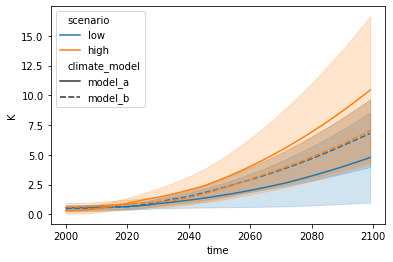

In [7]:
# NBVAL_IGNORE_OUTPUT
run_append([runs_low, runs_high]).line_plot(hue="scenario", style="climate_model")

In [8]:
database.save_to_database(runs_low)

In [9]:
!pushd {temp_out_dir.name}; tree; popd

.
├── model_a
│   └── low
│       └── model_a_low.nc
└── model_b
    └── low
        └── model_b_low.nc

4 directories, 2 files


In [10]:
# Additional saves will merge the data, creating any new files as required
database.save_to_database(runs_high)

In [11]:
!pushd {temp_out_dir.name}; tree; popd

.
├── model_a
│   ├── high
│   │   └── model_a_high.nc
│   └── low
│       └── model_a_low.nc
└── model_b
    ├── high
    │   └── model_b_high.nc
    └── low
        └── model_b_low.nc

6 directories, 4 files


If existing data is found, it is first loaded and merged with the saved data before writing so not to lose existing data. 

These data still need unique metadata otherwise a `NonUniqueMetadataError` is raised.

In [12]:
try:
    database.save_to_database(runs_high)
except NonUniqueMetadataError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
scmdata.errors.NonUniqueMetadataError: Duplicate metadata (numbers show how many times the given metadata is repeated).
  climate_model ensemble_member    model region scenario unit  \
0       model_a               0  example  World     high    K   
1       model_a               1  example  World     high    K   
2       model_a               2  example  World     high    K   
3       model_a               3  example  World     high    K   
4       model_a               4  example  World     high    K   
5       model_a               5  example  World     high    K   
6       model_a               6  example  World     high    K   
7       model_a               7  example  World     high    K   
8       model_a               8  example  World     high    K   
9       model_a               9  example  World     high    K   

              variable  repeats  
0  Surface Temperature        2  
1  Surface Temperature        2  
2  Surface Temperature     

In [13]:
runs_high_extra = runs_high.copy()
runs_high_extra["ensemble_member"] = runs_high_extra["ensemble_member"] + 10
database.save_to_database(runs_high_extra)

## Loading data

When loading data we can select a subset of data, similar to `ScmRun.filter` but limited to filtering for the metadata columns as specified in `levels`

In [14]:
run = database.load_data(scenario="high")
run

<scmdata.ScmRun (timeseries: 40, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	   climate_model  ensemble_member    model region scenario unit  \
	0        model_a                0  example  World     high    K   
	1        model_a                1  example  World     high    K   
	2        model_a                2  example  World     high    K   
	3        model_a                3  example  World     high    K   
	4        model_a                4  example  World     high    K   
	5        model_a                5  example  World     high    K   
	6        model_a                6  example  World     high    K   
	7        model_a                7  example  World     high    K   
	8        model_a                8  example  World     high    K   
	9        model_a                9  example  World     high    K   
	10       model_a               10  example  World     high    K   
	11       model_a               11  example  World     high    K   

In [15]:
database.load_data(climate_model="model_b")

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	   climate_model  ensemble_member    model region scenario unit  \
	0        model_b                0  example  World     high    K   
	1        model_b                1  example  World     high    K   
	2        model_b                2  example  World     high    K   
	3        model_b                3  example  World     high    K   
	4        model_b                4  example  World     high    K   
	5        model_b                5  example  World     high    K   
	6        model_b                6  example  World     high    K   
	7        model_b                7  example  World     high    K   
	8        model_b                8  example  World     high    K   
	9        model_b                9  example  World     high    K   
	10       model_b               10  example  World     high    K   
	11       model_b               11  example  World     high    K   

The entire dataset can also be loaded if needed. This may not be possible for very large datasets depending on the amount of system memory available.

In [16]:
all_data = database.load_data()
all_data

<scmdata.ScmRun (timeseries: 60, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	   climate_model  ensemble_member    model region scenario unit  \
	0        model_a                0  example  World     high    K   
	1        model_a                1  example  World     high    K   
	2        model_a                2  example  World     high    K   
	3        model_a                3  example  World     high    K   
	4        model_a                4  example  World     high    K   
	5        model_a                5  example  World     high    K   
	6        model_a                6  example  World     high    K   
	7        model_a                7  example  World     high    K   
	8        model_a                8  example  World     high    K   
	9        model_a                9  example  World     high    K   
	10       model_a               10  example  World     high    K   
	11       model_a               11  example  World     high    K   

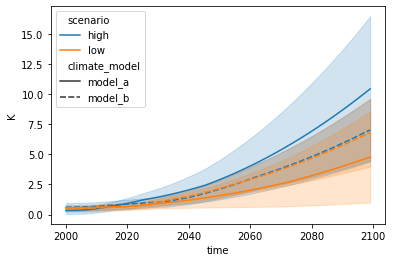

In [17]:
#NBVAL_IGNORE_OUTPUT
all_data.line_plot(hue="scenario", style="climate_model")

In [18]:
temp_out_dir.cleanup()